In [1]:
import sys
sys.path.append("../")  # path contains python_file.py

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import iris
import math

from scipy.stats import norm, laplace, gamma

from PACKAGE_NAME.variables import tas, pr
from PACKAGE_NAME.utils import gen_PrecipitationHurdleModel, gen_PrecipitationGammaLeftCensoredModel

from PACKAGE_NAME.debias import ECDFM, ISIMIP, QuantileMapping, DeltaChange, CDFt
from PACKAGE_NAME.debias import QuantileDeltaMapping, ScaledDistributionMapping, LinearScaling

from PACKAGE_NAME.evaluate import metrics, marginal, spatial, testing_assumptions
from PACKAGE_NAME.evaluate import spatiotemporal_extent, trend, spatiotemporal_correlation, GEV

**Set variables and metrics to investigate**

In [3]:
# define thresholds

metrics_dictionary = {
    "frost": {
        "variable": 'tasmin',
        "variable_name": '2m daily minimum air temperature (K)',
        "value": 273.15,
        "threshold_sign": 'lower',
        "name": 'Frost days'
    },
    "mean_warm_day": {
        "variable": 'tas',
        "variable_name": '2m daily mean air temperature (K)',
        "value": 295,
        "threshold_sign": 'higher',
        "name": 'Warm days (mean)'
    },
    "mean_cold_day": {
        "variable": 'tas',
        "variable_name": '2m daily mean air temperature (K)',
        "value": 273,
        "threshold_sign": 'lower',
        "name": 'Cold days (mean)'
    },
        "dry": {
        "variable": 'pr',
        "variable_name": 'Precipitation',
        "value": 0.000001,
        "threshold_sign": 'lower',
        "name": 'Dry days'
    },
        "wet": {
        "variable": 'pr',
        "variable_name": 'Precipitation',
        "value": 1/86400,
        "threshold_sign": 'higher',
        "name": 'Wet days (daily total precipitation > 1 mm)'
    }
}

In [4]:
lower_quantile = 0.05
higher_quantile = 0.95

In [5]:
variables = ['tas', 'pr', 'tasmin']

In [6]:
tas_metrics = ['mean_warm_day', 'mean_cold_day']
pr_metrics = ['dry', 'wet']
tasmin_metrics = ['frost']

In [29]:
str(tas_obs_validate)

'[[[291.37204 291.0145 ]\n  [291.6239  291.03625]]\n\n [[291.43982 291.92096]\n  [291.7866  292.08167]]\n\n [[290.51993 291.0519 ]\n  [290.94785 291.42108]]\n\n ...\n\n [[270.0164  269.8536 ]\n  [270.1928  269.1719 ]]\n\n [[273.8049  272.61264]\n  [272.4667  270.88065]]\n\n [[277.44678 276.1136 ]\n  [276.77866 275.3741 ]]]'

# 1. Data import and pre-processing

In [7]:
from cf_units import num2date

def get_dates(x):
    time_dimension = x.coords()[2]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates

def preprocess_isimip_evaluation_testing_data(variable):
    
    obs_all = iris.load_cube("testing_data/ISIMIP/"+variable+"_obs-hist_coarse_1979-2014.nc")
    cm = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-hist_coarse_1979-2014.nc")
    
    obs = obs_all[:, :, 0:9000]
    obs_validate = obs_all[:, :, 9001:]
    cm_hist = cm[:, :, 0:9000]
    cm_validate = cm[:, :, 9001:]
    
    cm_future = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-fut_coarse_2065-2100.nc")

    dates = {
        "time_obs": get_dates(obs),
        "time_cm_hist": get_dates(cm_hist),
        "time_cm_future": get_dates(cm_validate),
    }
    
    dates_future = {
        "time_obs": get_dates(obs),
        "time_cm_hist": get_dates(cm_hist),
        "time_cm_future": get_dates(cm_future),
    }
    
    obs = np.transpose(np.array(obs.data), (2, 0, 1))
    obs_validate = np.transpose(np.array(obs_validate.data), (2, 0, 1))
    cm_hist = np.transpose(np.array(cm_hist.data), (2, 0, 1))
    cm_validate = np.transpose(np.array(cm_validate.data), (2, 0, 1))
    cm_future = np.transpose(np.array(cm_future.data), (2, 0, 1))
    
    return obs, obs_validate, cm_hist, cm_validate, cm_future, dates, dates_future


In [8]:
tas_obs, tas_obs_validate, tas_cm_hist, tas_cm_validate, tas_cm_future, tas_dates_validate, tas_dates_future = preprocess_isimip_evaluation_testing_data('tas')
pr_obs, pr_obs_validate, pr_cm_hist, pr_cm_validate, pr_cm_future, pr_dates_validate, pr_dates_future = preprocess_isimip_evaluation_testing_data('pr')

# 2. Evaluation part one - test assumptions

## 2. 1. Parametric methods: goodness of fit assessment + seasonality

For all parametric methods, distributions are fitted to the CDFs. Default distributions are specified in the individual debiasers. In this evaluation step, the default distributions of the specified debiasers are fitted to the data so that the user can decide whether or not to go ahead with this particular distribution or method, or whether to modify it.

In the example below, the goodness of fit of the default distribution fitted to temperature data is assessed. 
- By calculating the Akaike Information Criterion and plotting the fit and distribution for the location with the worst fit for visual inspection. If a user modifies the distribution she can compare whether this improves the fit according to the AIC
- By evaluating the quantile residuals (timeseries, their autocorrelation and a qq-plot of their transformation to normal) - in this example we see that there is a strong seasonal effect present that the normal distribution does not capture.

**Distribution of AIC**

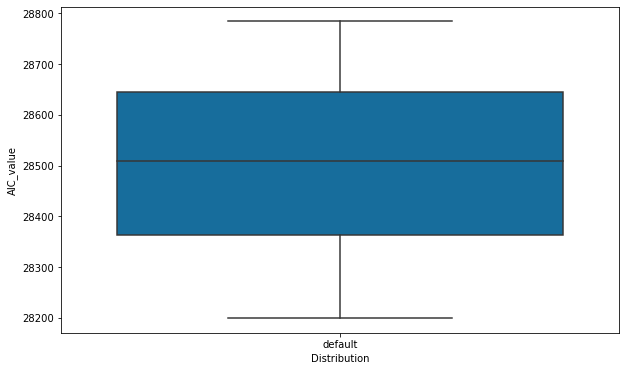

In [9]:
tas_obs_aic_default = testing_assumptions.calculate_aic_goodness_of_fit(variable = 'tas', dataset = tas_obs_validate)
testing_assumptions.plot_aic_goodness_of_fit(variable = 'tas', aic_data = tas_obs_aic_default)

**Visual inspection of fit at 'worst' location**

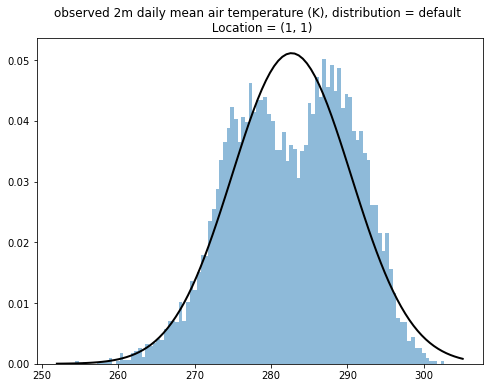

In [10]:
tas_obs_worst_fit = testing_assumptions.plot_worst_fit_aic(variable = 'tas', dataset = tas_obs, 
                                      aic = tas_obs_aic_default, 
                                      data_type = 'observed')

**Inspection of quantile residuals**

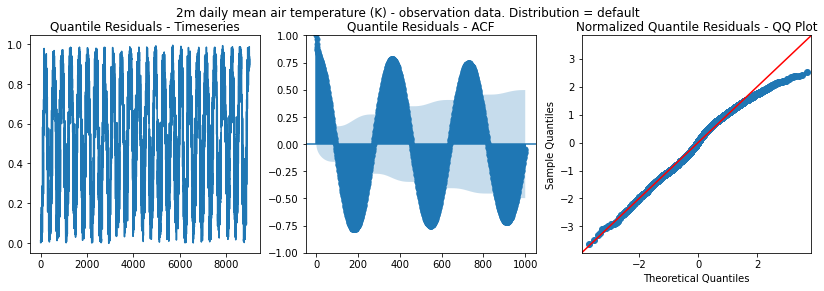

In [11]:
tas_obs_plot_gof = testing_assumptions.plot_quantile_residuals(dataset = tas_obs[:,0,0], 
                                                        variable = 'tas', data_type = 'observation data')

## 2. 2. Stationarity / Stability of results

Thoughts: this is an end-of-august add-on

## 2.3. Climate change trend

This could be a qq plot - could also be an optional analysis because we are already looking at trend preservation later

# 3. Initialise and apply de-biasers

**Quantile Mapping**

In [9]:
# Temperature
tas_debiaser_QM = QuantileMapping.from_variable(variable=tas, detrending="additive")
tas_val_debiased_QM = tas_debiaser_QM.apply(tas_obs, tas_cm_hist, tas_cm_validate)
tas_fut_debiased_QM = tas_debiaser_QM.apply(tas_obs, tas_cm_hist, tas_cm_future)

# Also debias historical climate model using quantile mapping
tas_debiased_hist = tas_debiaser_QM.apply(tas_obs, tas_cm_hist, tas_cm_hist)

----- Running debiasing -----


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 743.37it/s]


----- Running debiasing -----


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 466.25it/s]


----- Running debiasing -----


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 297.09it/s]


In [10]:
# Precipitation
hurdle_model = gen_PrecipitationHurdleModel(distribution = gamma)
left_censored_model = gen_PrecipitationGammaLeftCensoredModel(censoring_threshold = 0.1/86400)

pr_debiaser_QM = QuantileMapping.for_precipitation(detrending = "multiplicative", distribution = hurdle_model)
pr_val_debiased_QM = pr_debiaser_QM.apply(pr_obs, pr_cm_hist, pr_cm_validate)
pr_fut_debiased_QM = pr_debiaser_QM.apply(pr_obs, pr_cm_hist, pr_cm_future)

pr_debiased_hist = pr_debiaser_QM.apply(pr_obs, pr_cm_hist, pr_cm_hist)

----- Running debiasing -----


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 162.95it/s]


----- Running debiasing -----


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 77.98it/s]


----- Running debiasing -----


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 101.79it/s]


**Equidistant CDF Matching**

In [11]:
# Temperature
tas_debiaser_ECDFM = ECDFM.from_variable(variable = "tas")
tas_val_debiased_ECDFM = tas_debiaser_ECDFM.apply(tas_obs, tas_cm_hist, tas_cm_validate)
tas_fut_debiased_ECDFM = tas_debiaser_ECDFM.apply(tas_obs, tas_cm_hist, tas_cm_future)

----- Running debiasing -----


  0%|                                                     | 0/4 [00:00<?, ?it/s]/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


----- Running debiasing -----


100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.70it/s]


In [12]:
# Precipitation
pr_debiaser_ECDFM = ECDFM.from_variable(variable = "pr")
pr_val_debiased_ECDFM = pr_debiaser_ECDFM.apply(pr_obs, pr_cm_hist, pr_cm_validate)
pr_fut_debiased_ECDFM = pr_debiaser_ECDFM.apply(pr_obs, pr_cm_hist, pr_cm_future)

----- Running debiasing -----


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 101.88it/s]


----- Running debiasing -----


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 39.28it/s]


**ISIMIP**

In [13]:
# ISIMIP
tas_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'tas')
tas_val_debiased_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_validate, **tas_dates_validate)
tas_fut_debiased_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_future, **tas_dates_future)

----- Running debiasing -----


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.90s/it]


----- Running debiasing -----


100%|█████████████████████████████████████████████| 4/4 [00:10<00:00,  2.71s/it]


In [14]:
pr_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'pr')
pr_val_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(pr_obs, pr_cm_hist, pr_cm_validate, **pr_dates_validate)
pr_fut_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(pr_obs, pr_cm_hist, pr_cm_future, **pr_dates_future)

----- Running debiasing -----


100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


----- Running debiasing -----


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.98s/it]


**CDFt**

In [15]:
tas_debiaser_CDFT = CDFt.from_variable(variable = 'tas')
tas_debiased_CDFT = tas_debiaser_CDFT.apply(tas_obs, tas_cm_hist, tas_cm_validate, **tas_dates_validate)

----- Running debiasing -----


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.24it/s]


In [16]:
pr_debiaser_CDFT = CDFt.from_variable(variable = 'pr')
pr_debiased_CDFT = pr_debiaser_CDFT.apply(pr_obs, pr_cm_hist, pr_cm_validate, **tas_dates_validate)

----- Running debiasing -----


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.57it/s]


**Delta Change**

In [17]:
tas_debiaser_DC = DeltaChange.from_variable(variable = "tas")
tas_val_debiased_DC = tas_debiaser_DC.apply(tas_obs, tas_cm_hist, tas_cm_validate)
tas_fut_debiased_DC = tas_debiaser_DC.apply(tas_obs, tas_cm_hist, tas_cm_future)

----- Running debiasing -----


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 3051.51it/s]


----- Running debiasing -----


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 2172.65it/s]


In [18]:
pr_debiaser_DC = DeltaChange.from_variable(variable = "pr")
pr_val_debiased_DC = pr_debiaser_DC.apply(pr_obs, pr_cm_hist, pr_cm_validate)
pr_fut_debiased_DC = pr_debiaser_DC.apply(pr_obs, pr_cm_hist, pr_cm_future)

----- Running debiasing -----


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 2212.19it/s]


----- Running debiasing -----


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1764.35it/s]


**Linear Scaling**

In [19]:
tas_debiaser_LS = LinearScaling.from_variable(variable = "tas")
tas_val_debiased_LS = tas_debiaser_LS.apply(tas_obs, tas_cm_hist, tas_cm_validate)
tas_fut_debiased_LS = tas_debiaser_LS.apply(tas_obs, tas_cm_hist, tas_cm_future)

----- Running debiasing -----


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 3144.16it/s]


----- Running debiasing -----


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1893.16it/s]


In [20]:
pr_debiaser_LS = LinearScaling.from_variable(variable = "pr")
pr_val_debiased_LS = pr_debiaser_LS.apply(pr_obs, pr_cm_hist, pr_cm_validate)
pr_fut_debiased_LS = pr_debiaser_LS.apply(pr_obs, pr_cm_hist, pr_cm_future)

----- Running debiasing -----


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 2996.47it/s]


----- Running debiasing -----


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 2124.24it/s]


**Quantile Delta Mapping**

In [21]:
tas_debiaser_QDM = QuantileDeltaMapping.from_variable(variable = "tas")
tas_val_debiased_QDM = tas_debiaser_QDM.apply(tas_obs, tas_cm_hist, tas_cm_validate)
tas_fut_debiased_QDM = tas_debiaser_QDM.apply(tas_obs, tas_cm_hist, tas_cm_future)

----- Running debiasing -----


  0%|                                                     | 0/4 [00:00<?, ?it/s]WARNING:root:
                    QuantileDeltaMapping runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
 25%|███████████▎                                 | 1/4 [00:00<00:00,  3.69it/s]WARNING:root:
                    QuantileDeltaMapping runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical dif

----- Running debiasing -----


  0%|                                                     | 0/4 [00:00<?, ?it/s]WARNING:root:
                    QuantileDeltaMapping runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
 25%|███████████▎                                 | 1/4 [00:02<00:07,  2.62s/it]WARNING:root:
                    QuantileDeltaMapping runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical dif

In [22]:
pr_debiaser_QDM = QuantileDeltaMapping.from_variable(variable = "pr")
pr_val_debiased_QDM = pr_debiaser_QDM.apply(pr_obs, pr_cm_hist, pr_cm_validate)
pr_fut_debiased_QDM = pr_debiaser_QDM.apply(pr_obs, pr_cm_hist, pr_cm_future)

----- Running debiasing -----


  0%|                                                     | 0/4 [00:00<?, ?it/s]WARNING:root:
                    QuantileDeltaMapping runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
/Users/fionaspuler/Documents/GitHub/isimipy/notebooks/../PACKAGE_NAME/utils/_math_utils.py:333: RuntimeWarning: invalid value encountered in log
  return -np.sum(scipy.stats.gamma.logpdf(x, a=params[0], scale=params[1])) - nr_censored_x * np.log(
 25%|███████████▎                                 | 1/4 [00:02<00:06,  2.14s/it]WARNING:root:
                    QuantileDeltaMapping runs without time-information for at least one of obs, cm_hi

----- Running debiasing -----


  0%|                                                     | 0/4 [00:00<?, ?it/s]WARNING:root:
                    QuantileDeltaMapping runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
 25%|███████████▎                                 | 1/4 [00:05<00:17,  5.92s/it]WARNING:root:
                    QuantileDeltaMapping runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical dif

**Scaled Distribution Mapping**

In [23]:
tas_debiaser_SDM = ScaledDistributionMapping.from_variable(variable = "tas")
tas_val_debiased_SDM = tas_debiaser_SDM.apply(tas_obs, tas_cm_hist, tas_cm_validate)
tas_fut_debiased_SDM = tas_debiaser_SDM.apply(tas_obs, tas_cm_hist, tas_cm_future)

----- Running debiasing -----


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 164.66it/s]


----- Running debiasing -----


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 128.99it/s]


In [24]:
pr_debiaser_SDM = ScaledDistributionMapping.from_variable(variable = "pr")
pr_val_debiased_SDM = pr_debiaser_SDM.apply(pr_obs, pr_cm_hist, pr_cm_validate)
pr_fut_debiased_SDM = pr_debiaser_SDM.apply(pr_obs, pr_cm_hist, pr_cm_future)

----- Running debiasing -----


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8268.71it/s]


----- Running debiasing -----


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7423.55it/s]


# 4. Evaluation of bias corrected results on validation period

After applying the bias correction methods chosen by the user, this section provides a default set of evaluation to assess both the performance of the bias corrected climate model, as well as to get an insight into potential larger biases of the underlying climate model that cannot be corrected through bias correction methods.

In order to assess the performance of a bias correction methods, we need underlying observations to compare the climate simulation to - this is not given in a future period that we actually want to apply bias correction to. We therefore split the historical period into a 'training' and a 'validation' period, and assess the performance of the BC on the validation period where results can still be compared to observations.

## 4. 1. Marginal distribution

Bias correction methods implemented in this package so far apply marginal corrections (i.e. they are applied location-wise) - as opposed to correcting spatial or temporal correlation etc. This sub-section evaluates the performance of the bias correction method in correcting these marginal aspects through three plots:

- boxplot with overview (similar to trend analysis) of mean, 5th and 95th percentile & metrics
- inspection of 'interesting' histograms
- spatial inspection of 'interesting' metrics
- spatiotemporal exploration of some metrics
- correlation structure overall
- GEV analysis of extremes

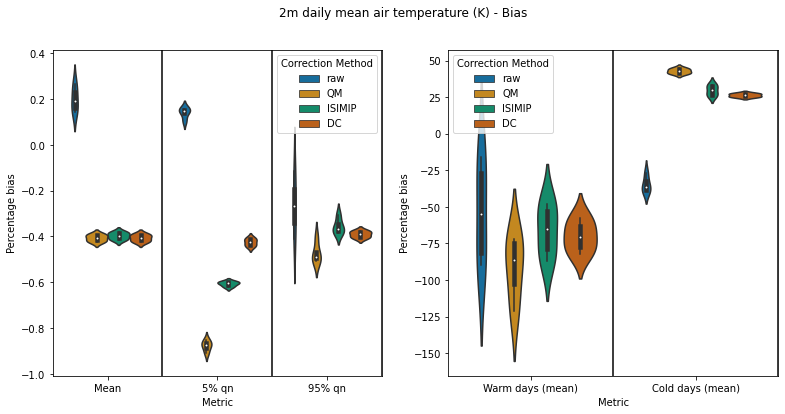

In [28]:
tas_marginal_bias_data = marginal.calculate_marginal_bias(metrics = tas_metrics,
                                                 obs = tas_obs,
                                                 raw = tas_cm_validate, 
                                                 QM = tas_val_debiased_QM,
                                                 ISIMIP = tas_val_debiased_ISIMIP,
                                                 DC = tas_val_debiased_DC)

tas_marginal_bias_plot = marginal.plot_marginal_bias(variable = 'tas', 
                                            bias_array = tas_marginal_bias_data, 
                                            metrics = tas_metrics)
tas_marginal_bias_plot

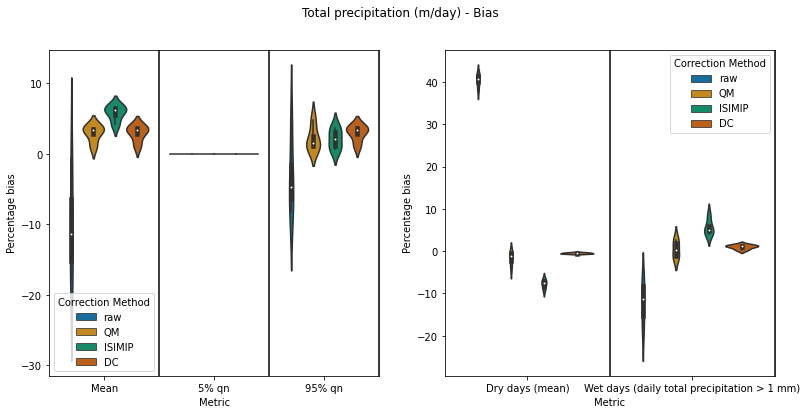

In [29]:
pr_marginal_bias_data = marginal.calculate_marginal_bias(variable = 'pr', 
                                                     metrics = pr_metrics,
                                                     obs = pr_obs,
                                                     raw = pr_cm_validate, 
                                                     QM = pr_val_debiased_QM,
                                                     ISIMIP = pr_val_debiased_ISIMIP,
                                                     DC = pr_val_debiased_DC)

pr_marginal_bias_plot = marginal.plot_marginal_bias(variable = 'pr', 
                                           bias_array = pr_marginal_bias_data,
                                           metrics = pr_metrics)
pr_marginal_bias_plot


In [ ]:
# include inspection of histograms

## 4.2. Spatial distribution

The shape of the distribution in the violinplot above already gives an indication of whether the bias is especially large over certain areas. The following plot explicitely shows the spacial distribution of biases. Particularly high biases in a certain region could point to deficiencies in the underlying climate model (for example, there could be a mountain range over which the climate model performs particularly badly, or other land-atmosphere interactions that are not captured).

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_34942/976352936.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_bias_map.show()


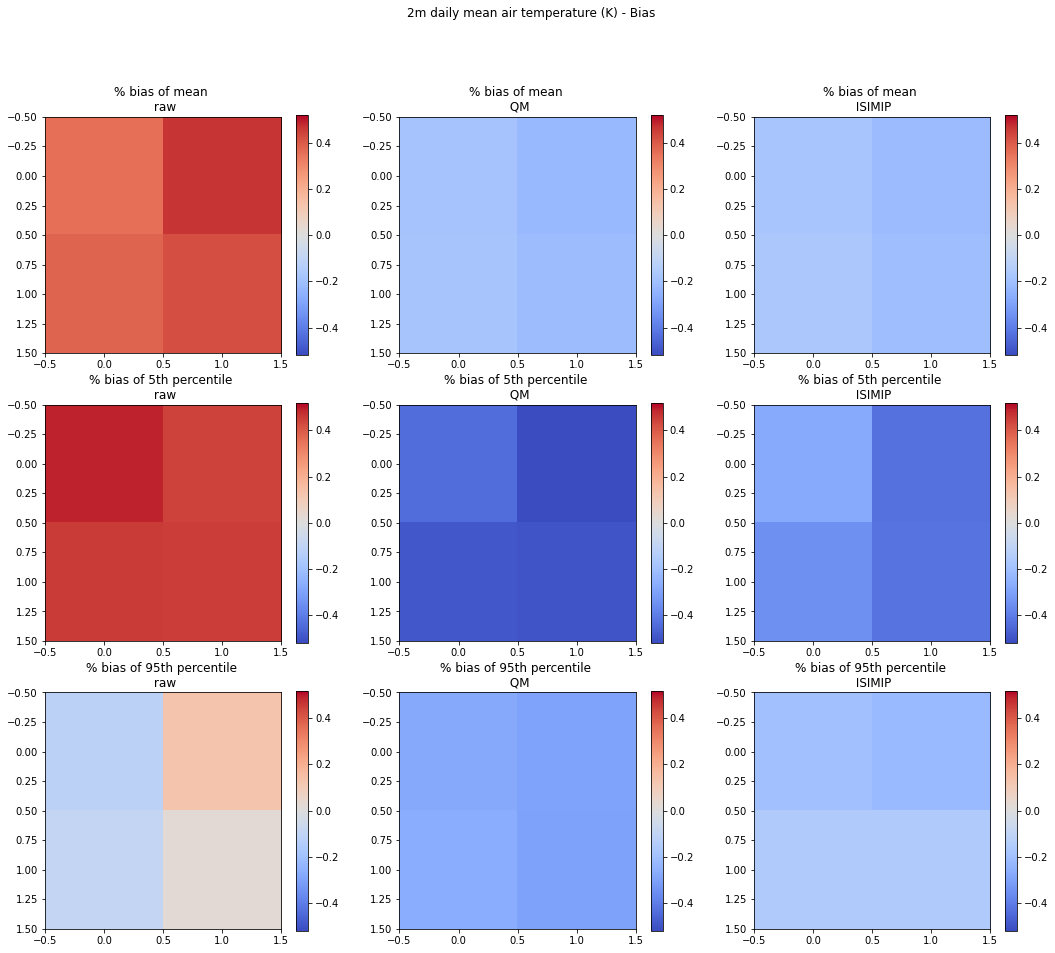

In [30]:
tas_bias_map = spatial.plot_bias_ds(variable = 'tas', 
                            data_obs = tas_obs_validate, 
                            raw = tas_cm_validate,
                            QM = tas_val_debiased_QM, 
                            ISIMIP = tas_val_debiased_ISIMIP)
tas_bias_map.show()

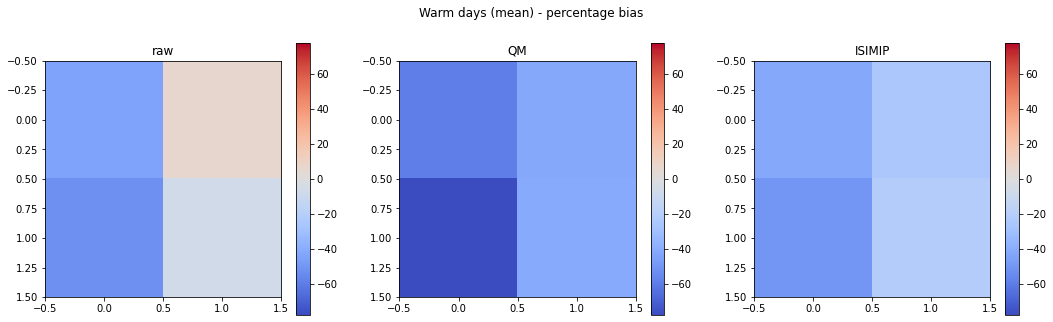

In [31]:
spatial.plot_bias_metrics(threshold_name = 'mean_warm_day', data_obs = tas_obs_validate, raw = tas_cm_validate,
                  QM = tas_val_debiased_QM, ISIMIP = tas_val_debiased_ISIMIP)

## 4.3. Spatiotemporal extent and correlation

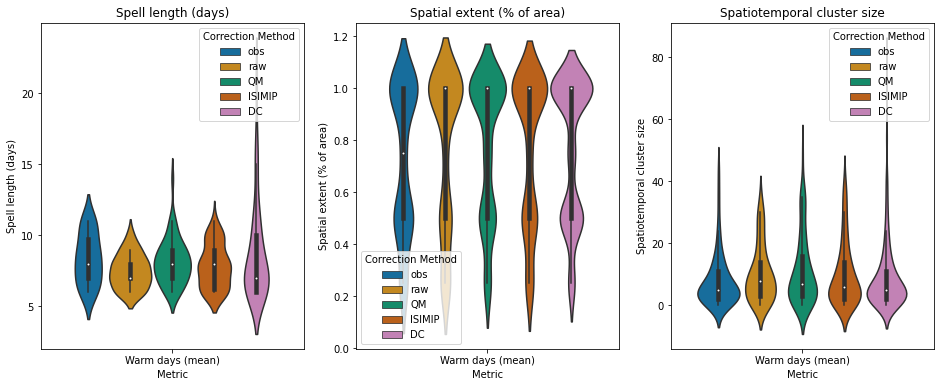

In [35]:
# warm day extent

fiveday_warm_spell_length, warm_spatial_clusters, warm_spatiotemporal_clusters = spatiotemporal_extent.calculate_clusters(metric = 'mean_warm_day', 
                                                   min_length = 5, obs = tas_obs_validate,
                                                   raw = tas_cm_validate, QM = tas_val_debiased_QM, 
                                                   ISIMIP = tas_val_debiased_ISIMIP, DC = tas_val_debiased_DC)

spatiotemporal_extent.plot_extent_distributions(fiveday_warm_spell_length, warm_spatial_clusters, warm_spatiotemporal_clusters)


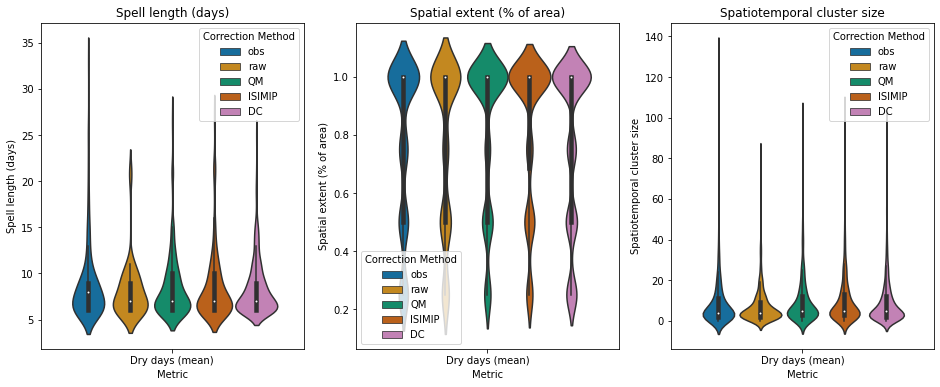

In [36]:
# dry day extent
fiveday_dry_spell_length, dry_spatial_clusters, dry_spatiotemporal_clusters = spatiotemporal_extent.calculate_clusters(metric = 'dry', 
                                                   min_length = 5, obs = pr_obs_validate,
                                                   raw = pr_cm_validate, QM = pr_val_debiased_QM, 
                                                   ISIMIP = pr_val_debiased_ISIMIP, DC = pr_val_debiased_DC)

spatiotemporal_extent.plot_extent_distributions(fiveday_dry_spell_length, dry_spatial_clusters, dry_spatiotemporal_clusters)

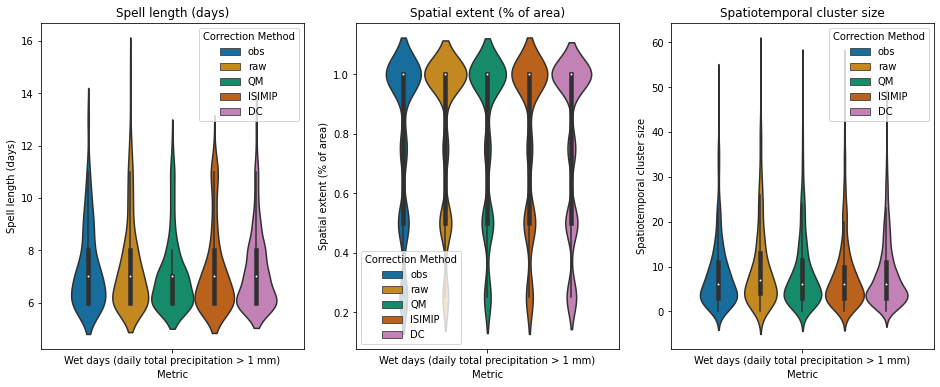

In [37]:
# wet day extent

fiveday_wet_spell_length, wet_spatial_clusters, wet_spatiotemporal_clusters = spatiotemporal_extent.calculate_clusters(metric = 'wet', 
                                                   min_length = 5, obs = pr_obs_validate,
                                                   raw = pr_cm_validate, QM = pr_val_debiased_QM, 
                                                   ISIMIP = pr_val_debiased_ISIMIP, DC = pr_val_debiased_DC)

spatiotemporal_extent.plot_extent_distributions(fiveday_wet_spell_length, wet_spatial_clusters, wet_spatiotemporal_clusters)

### Spatial correlation - distribution of RMSE between two correlation matrices

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_34942/460523678.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_rmsd_spatial_plot.show()


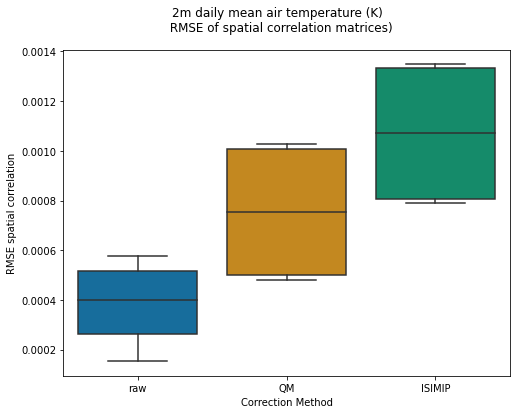

In [39]:
tas_rmsd_spatial = spatiotemporal_correlation.rmse_spatial_correlation_distribution(variable = 'tas', 
                                                         obs_data = tas_obs_validate, 
                                                         raw = tas_cm_future,
                                                         QM = tas_val_debiased_QM,
                                                         ISIMIP = tas_val_debiased_ISIMIP)
tas_rmsd_spatial_plot = spatiotemporal_correlation.rmse_spatial_correlation_boxplot(variable = 'tas', dataset = tas_rmsd_spatial)
tas_rmsd_spatial_plot.show()

### Temporal structure - Autocorrelation function

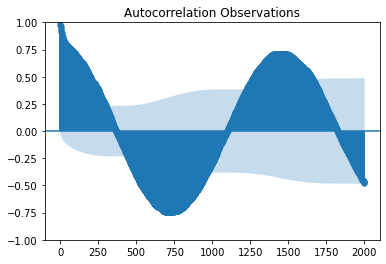

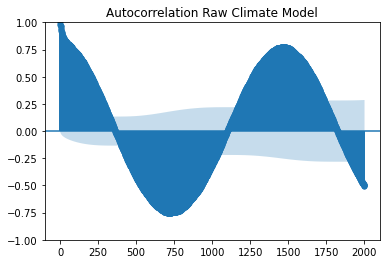

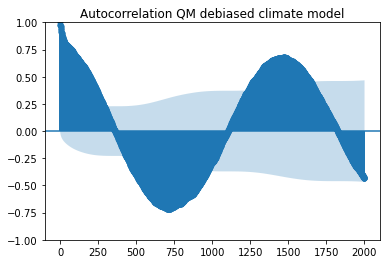

In [41]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(np.ndarray.flatten(tas_obs_validate), lags=2000)
plt.title('Autocorrelation Observations')
plt.show()

# TODO - think about whether np.ndarray.flatten makes sense here

plot_acf(np.ndarray.flatten(tas_cm_future), lags=2000)
plt.title('Autocorrelation Raw Climate Model')
plt.show()

plot_acf(np.ndarray.flatten(tas_val_debiased_QM), lags=2000)
plt.title('Autocorrelation QM debiased climate model')
plt.show()

# Idea: look at minima and maxima and their timing?

### Multivariate structure - difference in correlation matrices

In [214]:
def multivariate_correlation(variables, **kwargs):
    
    correlation_matrix = {}
    
    for k in kwargs.keys():
        
        variable1 = kwargs[k][0]
        variable2 = kwargs[k][1]
        
        correlation_matrix[k] = np.zeros((variable1.shape[1], variable1.shape[2]))
    
        for i in range(variable1.shape[1]):
                for j in range(variable1.shape[2]):
                            
                        correlation_matrix[k][i,j] = np.corrcoef(variable1[:,i,j].T, variable2[:,i,j].T)[0,1]

    axis_max = max(abs(max(np.ndarray.flatten(np.vstack(list(chain(*correlation_matrix.values())))))), 
                   abs(min(np.ndarray.flatten(np.vstack(list(chain(*correlation_matrix.values())))))))
    axis_min = -axis_max
    
    fig_width = 6*len(kwargs.keys())
    fig, ax = plt.subplots(1, len(kwargs.keys()), figsize=(fig_width, 5))
    fig.suptitle("Multivariate Correlation: {} and {}".format(variable_dictionary.get(variables[0]).get('name'),
                                                              variable_dictionary.get(variables[1]).get('name')))
    
    i=0
    for k in kwargs.keys():
        
        plot = ax[i].imshow(correlation_matrix[k], cmap=plt.get_cmap('coolwarm'), vmin = axis_min, vmax = axis_max)
        ax[i].set_title('{}'.format(k))
        fig.colorbar(plot, ax=ax[i])
        i = i+1
        
    return(fig)

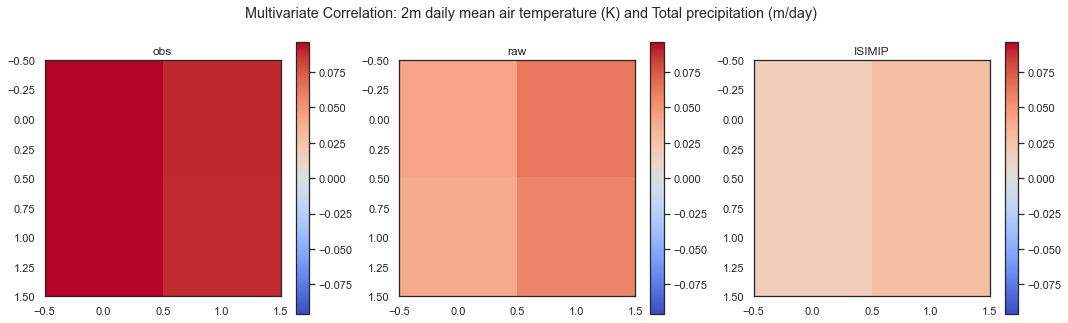

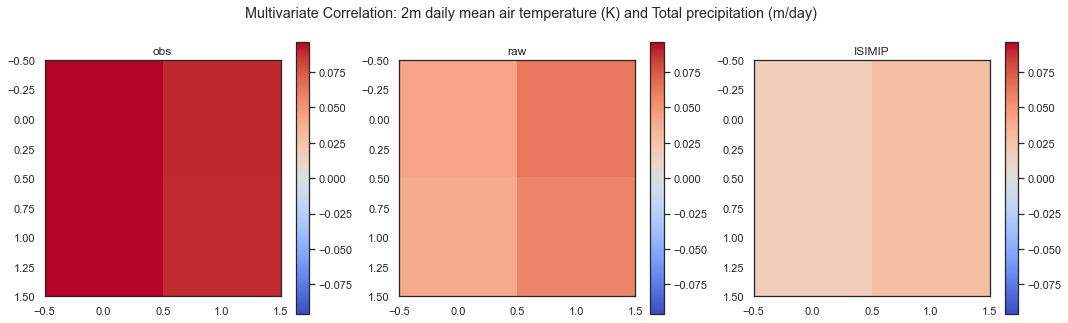

In [215]:
multivariate_correlation(variables = ['tas', 'pr'], obs = [tas_obs_validate, pr_obs_validate], 
                         raw = [tas_cm_validate, pr_cm_validate], ISIMIP = [tas_val_debiased_ISIMIP, pr_val_debiased_ISIMIP])

<AxesSubplot:xlabel='tas', ylabel='pr'>

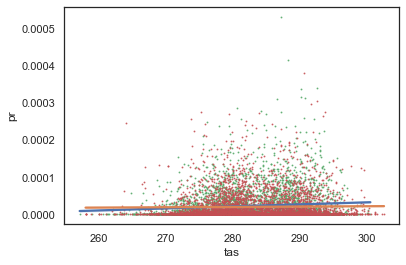

In [236]:
import seaborn
import pandas as pd

obs_dataset = pd.DataFrame(columns=['tas', 'pr'])
obs_dataset['tas'] = tas_obs_validate[:, 0,0]
obs_dataset['pr'] = pr_obs_validate[:, 0,0]

isimip_dataset = pd.DataFrame(columns=['tas', 'pr'])
isimip_dataset['tas'] = tas_val_debiased_ISIMIP[:, 0,0]
isimip_dataset['pr'] = pr_val_debiased_ISIMIP[:, 0,0]

seaborn.set_style('white')

seaborn.regplot(x="tas", y="pr", data=obs_dataset, ci=95, scatter_kws={'s': 0.8, 'color':'g'}) 
           #line_kws={'lw': 2, 'color': '#4682b4'})
seaborn.regplot(x="tas", y="pr", data=isimip_dataset, ci=95, scatter_kws={'s': 0.8, 'color':'r'})     

KstestResult(statistic=0.998, pvalue=7.399507995628047e-297)

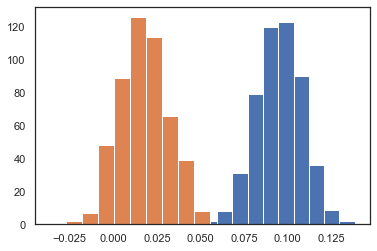

In [219]:
from scipy.stats import kstest

def draw_bs_replicates(data,size):

    corr_replicates = np.empty(size)

    for i in range(size):
        
        bs_sample = data.sample(n=data.shape[0], replace=True)
        
        corr_replicates[i] = bs_sample['pr'].corr(bs_sample['tas'])
    
    return corr_replicates



corr_estimates_obs = draw_bs_replicates(obs_dataset, 500)
corr_estimates_isimip = draw_bs_replicates(isimip_dataset, 500)

plt.hist(corr_estimates_obs)
plt.hist(corr_estimates_isimip)

kstest(corr_estimates_obs, corr_estimates_isimip, 'auto')

(array([  9.,  59., 121.,  82.,  45.,  54.,  74.,  33.,  16.,   7.]),
 array([0.17007672, 0.17848011, 0.1868835 , 0.1952869 , 0.20369029,
        0.21209368, 0.22049707, 0.22890046, 0.23730385, 0.24570724,
        0.25411063]),
 <BarContainer object of 10 artists>)

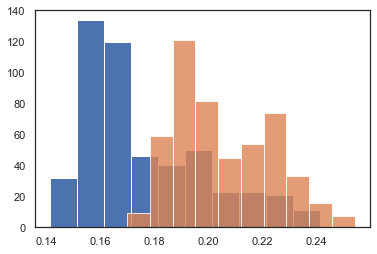

In [237]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def draw_bs_replicates_mi(data,bins, size):

    corr_replicates = np.empty(size)

    for i in range(size):
        
        bs_sample = data.sample(n=data.shape[0], replace=True).to_numpy()
        
        corr_replicates[i] = calc_MI(bs_sample[:, 0], bs_sample[:, 1], bins)
    
    return corr_replicates

mi_estimates_obs = draw_bs_replicates_mi(obs_dataset, 50, 500)
mi_estimates_isimip = draw_bs_replicates_mi(isimip_dataset, 50, 500)

plt.hist(mi_estimates_obs)
plt.hist(mi_estimates_isimip, alpha=0.8)

In [226]:
test = obs_dataset.to_numpy()
test[:, 0]

array([291.37204, 291.43982, 290.51993, ..., 270.0164 , 273.8049 ,
       277.44678], dtype=float32)

# 5. Trend preservation

**To-do: revise text**

Quantile Mapping does not automatically preserve the trend in the climate model - in fact, Switanek et al (2017) show that the trend can be distorted by quantile mapping by the order of magnitude of the trend itself. ISIMIP on the other hand is a trend preserving bias correction methodology. 

Whether or not to modify the trend modelled by the climate model is a choice the user has to make - to evaluate whether the trend of the climate model is plausible requires more in-depth diagnostics of the climate model, for example of the kind available through ESMValTools. 

What we can do within this package is simply to show whether the bias correction that the user has applied has modified the climate change trend present in the model - and refer the user to other tools for further analysis.

The way this is currently implemented is WIP, in principle based on Switanek et al 2017. The observed trend between training (1979-2000) and validation period (2000-2014) is compared between observed data, and raw and bias adjusted climate model data.

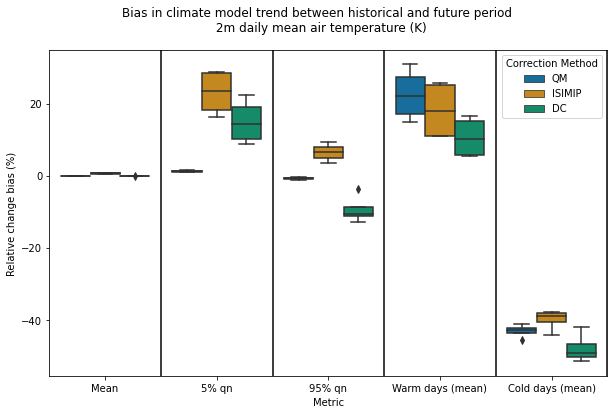

In [25]:
tas_trend_bias_data = trend.calculate_future_trend_bias(variable = 'tas', metrics = ['mean_warm_day', 'mean_cold_day'], 
                                                  raw_validate = tas_cm_validate, raw_future = tas_cm_future, 
                                                  QM = [tas_val_debiased_QM, tas_fut_debiased_QM],
                                                  ISIMIP = [tas_val_debiased_ISIMIP, tas_fut_debiased_ISIMIP],
                                                  DC = [tas_val_debiased_DC, tas_fut_debiased_DC])

trend.plot_future_trend_bias(variable ='tas', bias_array = tas_trend_bias_data)

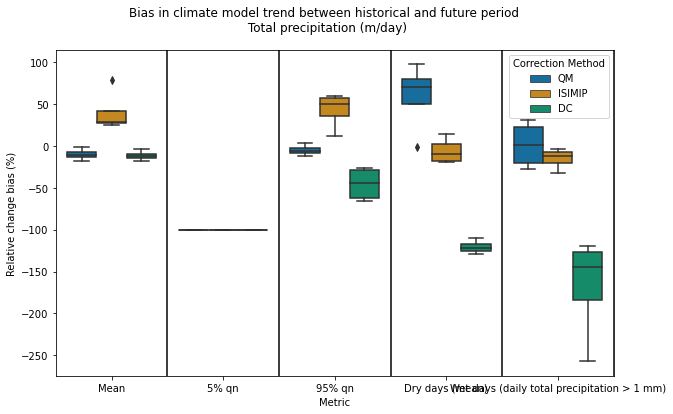

In [26]:
pr_trend_bias_data = trend.calculate_future_trend_bias(variable = 'pr', metrics = ['dry', 'wet'], 
                                                  raw_validate = pr_cm_validate, raw_future = pr_cm_future, 
                                                  QM = [pr_val_debiased_QM, pr_fut_debiased_QM],
                                                  ISIMIP = [pr_val_debiased_ISIMIP, pr_fut_debiased_ISIMIP],
                                                  DC = [pr_val_debiased_DC, pr_fut_debiased_DC])

trend.plot_future_trend_bias(variable ='pr', bias_array = pr_trend_bias_data)

# Conclusion

Overall, the Quantile Mapping method implemented in this example performs quite badly:
- there is a clear bimodality (and associated seasonality) in the data that the fit does not account for
- the bias correction 'overcorrects' the bias in both mean as well as high and low quantiles
- the bias adjusted CM performs as bad or worse as the raw CM in representing the probability of hot and cold days
- the length of both hot and cold spells is overestimated by the bias corrected model